In [16]:
import scanpy as sc
import geopandas as gpd
import numpy as np
from pathlib import Path

In [17]:
base_folder = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject")
adata_file  = base_folder / "data/cell_segmentation/concatenated/combined_adata.h5ad"
gpk_file    = base_folder / "data/cell_segmentation/concatenated/combined_nuclei_geometry.gpkg"

adata   = sc.read_h5ad(adata_file)
geo_df  = gpd.read_file(gpk_file)

In [18]:
# Creating centroids
geo_df["centroid"]    = geo_df.geometry.centroid
geo_df["centroid_x"]  = geo_df.centroid.x
geo_df["centroid_y"]  = geo_df.centroid.y

In [19]:
# Index by the cell ID column
geo_centroids = geo_df.set_index("id")[["centroid_x", "centroid_y"]]

In [21]:
adata.obs = adata.obs.join(geo_centroids, how="left")

In [22]:
coords = adata.obs[["centroid_x", "centroid_y"]].to_numpy()

In [23]:
adata.obsm["spatial"] = coords

In [25]:
adata.obs['TMA'].unique()

['F07833', 'F07834', 'F07835', 'F07836', 'F07837', 'F07838']
Categories (6, object): ['F07833', 'F07834', 'F07835', 'F07836', 'F07837', 'F07838']

In [26]:
adata.write_h5ad(adata_file)

# Sanity check

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Reload and subset as before
base = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject")
adata = sc.read_h5ad(base / "data/cell_segmentation/concatenated/combined_adata.h5ad")
subset = adata[adata.obs['TMA'] == "F07833"].copy()

# Ensure total_umis column exists
if 'total_umis' not in subset.obs:
    X = subset.X
    if hasattr(X, "toarray"): 
        total_umis = np.array(X.sum(axis=1)).ravel()
    else:
        total_umis = X.sum(axis=1)
    subset.obs['total_umis'] = total_umis

# Pull coords and raw UMIs
coords = subset.obsm['spatial']
umis   = subset.obs['total_umis'].values



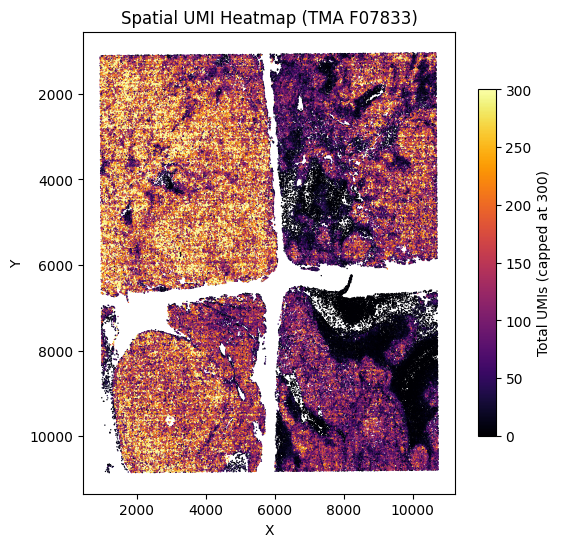

In [33]:
# Cap at 300
umis_capped = np.clip(umis, 0, 300)

# Plot colored scatter (“heatmap”)
plt.figure(figsize=(6,6))
sc = plt.scatter(
    coords[:,0], coords[:,1],
    c=umis_capped,
    cmap='inferno',
    s=1,            # fixed point size
    edgecolors='none',
    vmin=0,
    vmax=300
)
cbar = plt.colorbar(sc, shrink=0.75)
cbar.set_label('Total UMIs (capped at 300)')
plt.title("Spatial UMI Heatmap (TMA F07833)")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().invert_yaxis()  # if needed to match image orientation
plt.show()